In [1]:
import pandas as pd
import numpy as np
from station import Station
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import mpld3

%load_ext autoreload
%autoreload

In [ ]:
station_summary = pd.read_csv('data/station_summary.csv')

In [ ]:
high_stds = station_summary.sort_values(by='daily_std', ascending=False).iloc[0:10]
high_stds.set_index('station', inplace=True)

In [2]:
# create geodataframe from stations with highest STDs
def create_geodf(df):
    df.set_index('station', inplace=True)
    geometry = [Point(x,y) for x,y in zip(df['longitude'], df['latitude'])]
    crs = {'init':'epsg:4326'}
    geo_df = gpd.GeoDataFrame(index=df.index, crs=crs, geometry=geometry)
    return geo_df

In [7]:
# check which neighborhood each point belongs in
def assign_neighborhood(geodf, neighdf):
    x=pd.DataFrame()
    assign_dict = {key: geom for key, geom in neighdf['geometry'].items()}
    assign_dict2 = {key: geodf.within(geom) for key, geom in assign_dict.items()}
    x = geodf.assign(**assign_dict2)
    x = x.loc[:, (x != 0).any(axis=0)]
    names=x.columns.tolist()
    names.remove('geometry')
    x['neighborhood'] = x[names].idxmax(axis=1)
    x.drop(columns=names, inplace=True)
    return x

In [8]:
# get polygons for each relevant neighborhood
def get_selected_neighborhoods(points,neighdf):
    for item in points['neighborhood']:
        inds = points.index[points['neighborhood']==item].tolist()
        points.loc[inds,'polygon'] = neighdf.loc[item, 'geometry']

    neighs_withpoints = points.copy()
    neighs_withpoints.rename(columns={'polygon':'geometry', 
                                      'geometry':'points'}, inplace=True)
    x = neighs_withpoints.representative_point().apply(lambda p: p.x)
    y = neighs_withpoints.representative_point().apply(lambda p: p.y)
    neighs_withpoints['xy']= [(x,y) for x,y in zip(x, y)]
    return neighs_withpoints

In [9]:
df = pd.read_csv('data/pie_stations_summary.csv')
df['pctchange_2018_2023'] = ((df['2023_predicted_mean']/df['2018_mean'])-1)*100
df=df.loc[0:2]

In [10]:
neighdf = gpd.read_file(
    'data/Boundaries - Community Areas/geo_export_c539fca7-2c77-4148-be09-2c656a4bc388.shp')
neighdf.set_index('community', inplace=True)
geodf = create_geodf(df)
station_points = assign_neighborhood(geodf,neighdf)
neighs_withpoints=get_selected_neighborhoods(station_points,neighdf)

INFO:fiona.ogrext:Failed to auto identify EPSG: 7


In [12]:
# run if some points fall in the same neighborhood 
for neigh in neighs_withpoints['neighborhood']:
    num = len(neighs_withpoints[neighs_withpoints['neighborhood']==neigh])
    locs = neighs_withpoints[neighs_withpoints['neighborhood']==neigh].index
    neighs_withpoints.loc[locs, 'freq']=num
neighs_only = neighs_withpoints.drop_duplicates(subset='neighborhood')

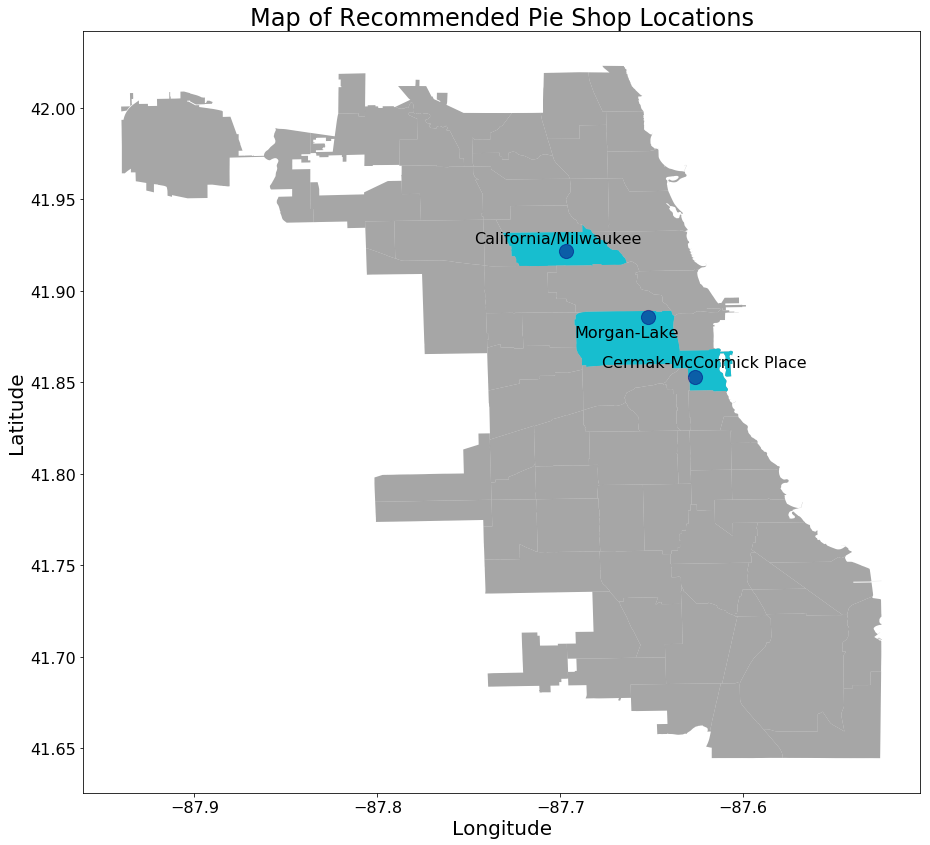

In [82]:
fig, ax = plt.subplots(figsize=(15,15))
neighdf.plot(ax=ax,alpha=.7, color='grey')
neighs_withpoints.plot(ax=ax, cmap='tab10', column='freq', vmin=-70, vmax=0)

for n, xy in zip(neighs_only.index.tolist(), neighs_only['xy'].tolist()):
    ax.annotate(n,  xy=xy, ha='center', va='bottom',
                color='k', fontsize=16)
station_points.plot(ax=ax, color='navy', marker='o', alpha=.5, markersize=200)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
plt.title('Map of Recommended Pie Shop Locations', fontsize=24)
plt.savefig('figs/map_pie_shop.png')

In [ ]:
# neigh_map = gpd.read_file(
#     'data/Boundaries - Community Areas/geo_export_c539fca7-2c77-4148-be09-2c656a4bc388.shp')

# neigh_map.set_index('community', inplace=True)
# assign_dict = {key: geom for key, geom in neigh_map['geometry'].items()}
# assign_dict2 = {key: geo_df.within(geom) for key, geom in assign_dict.items()}
# # check which neighborhood each station falls in
# station_to_neigh = geo_df.assign(**assign_dict2)
# station_to_neigh = station_to_neigh.loc[:, (station_to_neigh != 0).any(axis=0)]
# ncols = ['LAKE VIEW', 'LOOP', 'ROSELAND', 'LINCOLN PARK']


# get representative coordinates from each neighborhood
# neigh_map['coords'] = neigh_map['geometry'].apply(
#     lambda x: x.representative_point().coords[:])
# neigh_map['coords'] = [coords[0] for coords in neigh_map['coords']]